## https://www.nature.com/articles/s41586-024-08048-x
### DNA 突变的三核苷酸突变特征

In [6]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [7]:
data = pd.read_csv('./mito_mutation_likelihoods_annotated.txt', sep='\t', low_memory=False)
data.head()

,POS,REF,ALT,Likelihood,trinucleotide,symbol,consequence,amino_acids,protein_position,codon_change,...,helix_max_hl,helix_af_hom,helix_af_het,mitomap_gbcnt,mitomap_af,mitomap_status,mitomap_plasmy,mitomap_disease,clinvar_interp,chimp_ref
0,1,G,T,0.141345,GGA,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,G
1,1,G,A,5.362866,GGA,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,G
2,1,G,C,0.103456,GGA,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,G
3,2,A,T,0.042339,GAT,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,A
4,2,A,C,0.040080,GAT,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,A


In [8]:
var_map = {
    'G>A': 'C>T', 
    'G>T': 'C>A', 
    'G>C': 'C>G',
    'A>T': 'T>A', 
    'A>G': 'T>C', 
    'A>C': 'T>G'
}
data.loc[:, 'var'] = data["REF"] + '>' + data["ALT"]
data.loc[:, 'var'] = data['var'].map(lambda x: var_map.get(x, x) if isinstance(x, str) else x)
data.loc[:, 'strand'] = np.where((data["REF"] == 'C') | (data["REF"] == 'T'), 'L', 'H')
# 计算各变异位点的比例
total_count = len(data)
data_prop = data.groupby(['var', 'strand']).size().reset_index(name='count')
data_prop['proportion'] = data_prop['count'] / total_count
data_prop.head()
data.head()

,POS,REF,ALT,Likelihood,trinucleotide,symbol,consequence,amino_acids,protein_position,codon_change,...,helix_af_het,mitomap_gbcnt,mitomap_af,mitomap_status,mitomap_plasmy,mitomap_disease,clinvar_interp,chimp_ref,var,strand
0,1,G,T,0.141345,GGA,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0,0.0,NaN,NaN,NaN,NaN,G,C>A,H
1,1,G,A,5.362866,GGA,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0,0.0,NaN,NaN,NaN,NaN,G,C>T,H
2,1,G,C,0.103456,GGA,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0,0.0,NaN,NaN,NaN,NaN,G,C>G,H
3,2,A,T,0.042339,GAT,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0,0.0,NaN,NaN,NaN,NaN,A,T>A,H
4,2,A,C,0.040080,GAT,NaN,intergenic_variant,NaN,NaN,NaN,...,0.0,0,0.0,NaN,NaN,NaN,NaN,A,T>G,H


In [11]:
import pandas as pd
from Bio.Seq import Seq

# 读取文件
file = pd.read_csv('./mito_mutation_likelihoods_annotated.txt', sep='\t')

# 转换突变表示为嘧啶取向
file['mut'] = file['REF'] + '>' + file['ALT']

# 使用字典映射替代多层ifelse，提高可读性和效率
mutation_map = {
    "G>T": "C>A",
    "G>A": "C>T", 
    "G>C": "C>G",
    "A>T": "T>A",
    "A>C": "T>G",
    "A>G": "T>C"
}

file['pyr_mut'] = file['mut'].replace(mutation_map)

# 定义反向互补函数
def get_reverse_complement(seq):
    """获取DNA序列的反向互补序列"""
    return str(Seq(seq).reverse_complement())

# 应用反向互补处理
file['pyr_tri'] = file.apply(lambda row: 
    get_reverse_complement(row['trinucleotide']) if row['REF'] in ['G', 'A'] 
    else row['trinucleotide'], axis=1)

# 创建链标识因子变量
file['strand'] = pd.Categorical(
    ['Heavy' if ref in ['G', 'A'] else 'Light' for ref in file['REF']],
    categories=['Light', 'Heavy'],
    ordered=True
)

# 添加标签
strand_labels = {
    'Light': 'Reference / Light', 
    'Heavy': 'Reverse complement / Heavy'
}
file['strand'] = file['strand'].map(strand_labels)

# 排除OriB-OriH区域 (m.191-16197)
for_plot = file[(file['POS'] > 191) & (file['POS'] < 16197)]
for_plot = for_plot[['Likelihood', 'trinucleotide', 'pyr_mut', 'pyr_tri', 'strand']].drop_duplicates()

/tmp/ipykernel_264/2567173606.py:5: DtypeWarning: Columns (5,7,8,9,17,18,19,20,22,23,24,25,26,35) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv('./mito_mutation_likelihoods_annotated.txt', sep='\t')


In [12]:
for_plot

,Likelihood,trinucleotide,pyr_mut,pyr_tri,strand
573,3.624333,ATA,T>C,ATA,Reference / Light
574,0.166416,ATA,T>A,ATA,Reference / Light
575,0.086250,ATA,T>G,ATA,Reference / Light
576,0.130984,TAC,T>A,GTA,Reverse complement / Heavy
577,0.167036,TAC,T>G,GTA,Reverse complement / Heavy
...,...,...,...,...,...
2152,0.040355,GAG,T>G,CTC,Reverse complement / Heavy
2153,2.532258,GAG,T>C,CTC,Reverse complement / Heavy
2655,1.433793,TCG,C>T,TCG,Reference / Light
2656,0.117548,TCG,C>A,TCG,Reference / Light


In [13]:
# 按照指定列进行分组求和
sum_plot = for_plot.groupby(['pyr_mut', 'pyr_tri', 'strand'])['Likelihood'].sum().reset_index()
sum_plot[(sum_plot['pyr_mut']=='C>A') & (sum_plot['Likelihood']!=0)]

/tmp/ipykernel_264/1679764896.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_plot = for_plot.groupby(['pyr_mut', 'pyr_tri', 'strand'])['Likelihood'].sum().reset_index()


,pyr_mut,pyr_tri,strand,Likelihood
0,C>A,ACA,Reference / Light,0.024476
1,C>A,ACA,Reverse complement / Heavy,0.154139
2,C>A,ACC,Reference / Light,0.056990
3,C>A,ACC,Reverse complement / Heavy,0.358892
4,C>A,ACG,Reference / Light,0.074579
5,C>A,ACG,Reverse complement / Heavy,0.469660
6,C>A,ACT,Reference / Light,0.074587
7,C>A,ACT,Reverse complement / Heavy,0.469709
16,C>A,CCA,Reference / Light,0.022237
17,C>A,CCA,Reverse complement / Heavy,0.140035


找到的突变类型: ['C>A' 'C>G' 'C>T' 'T>A' 'T>C' 'T>G']


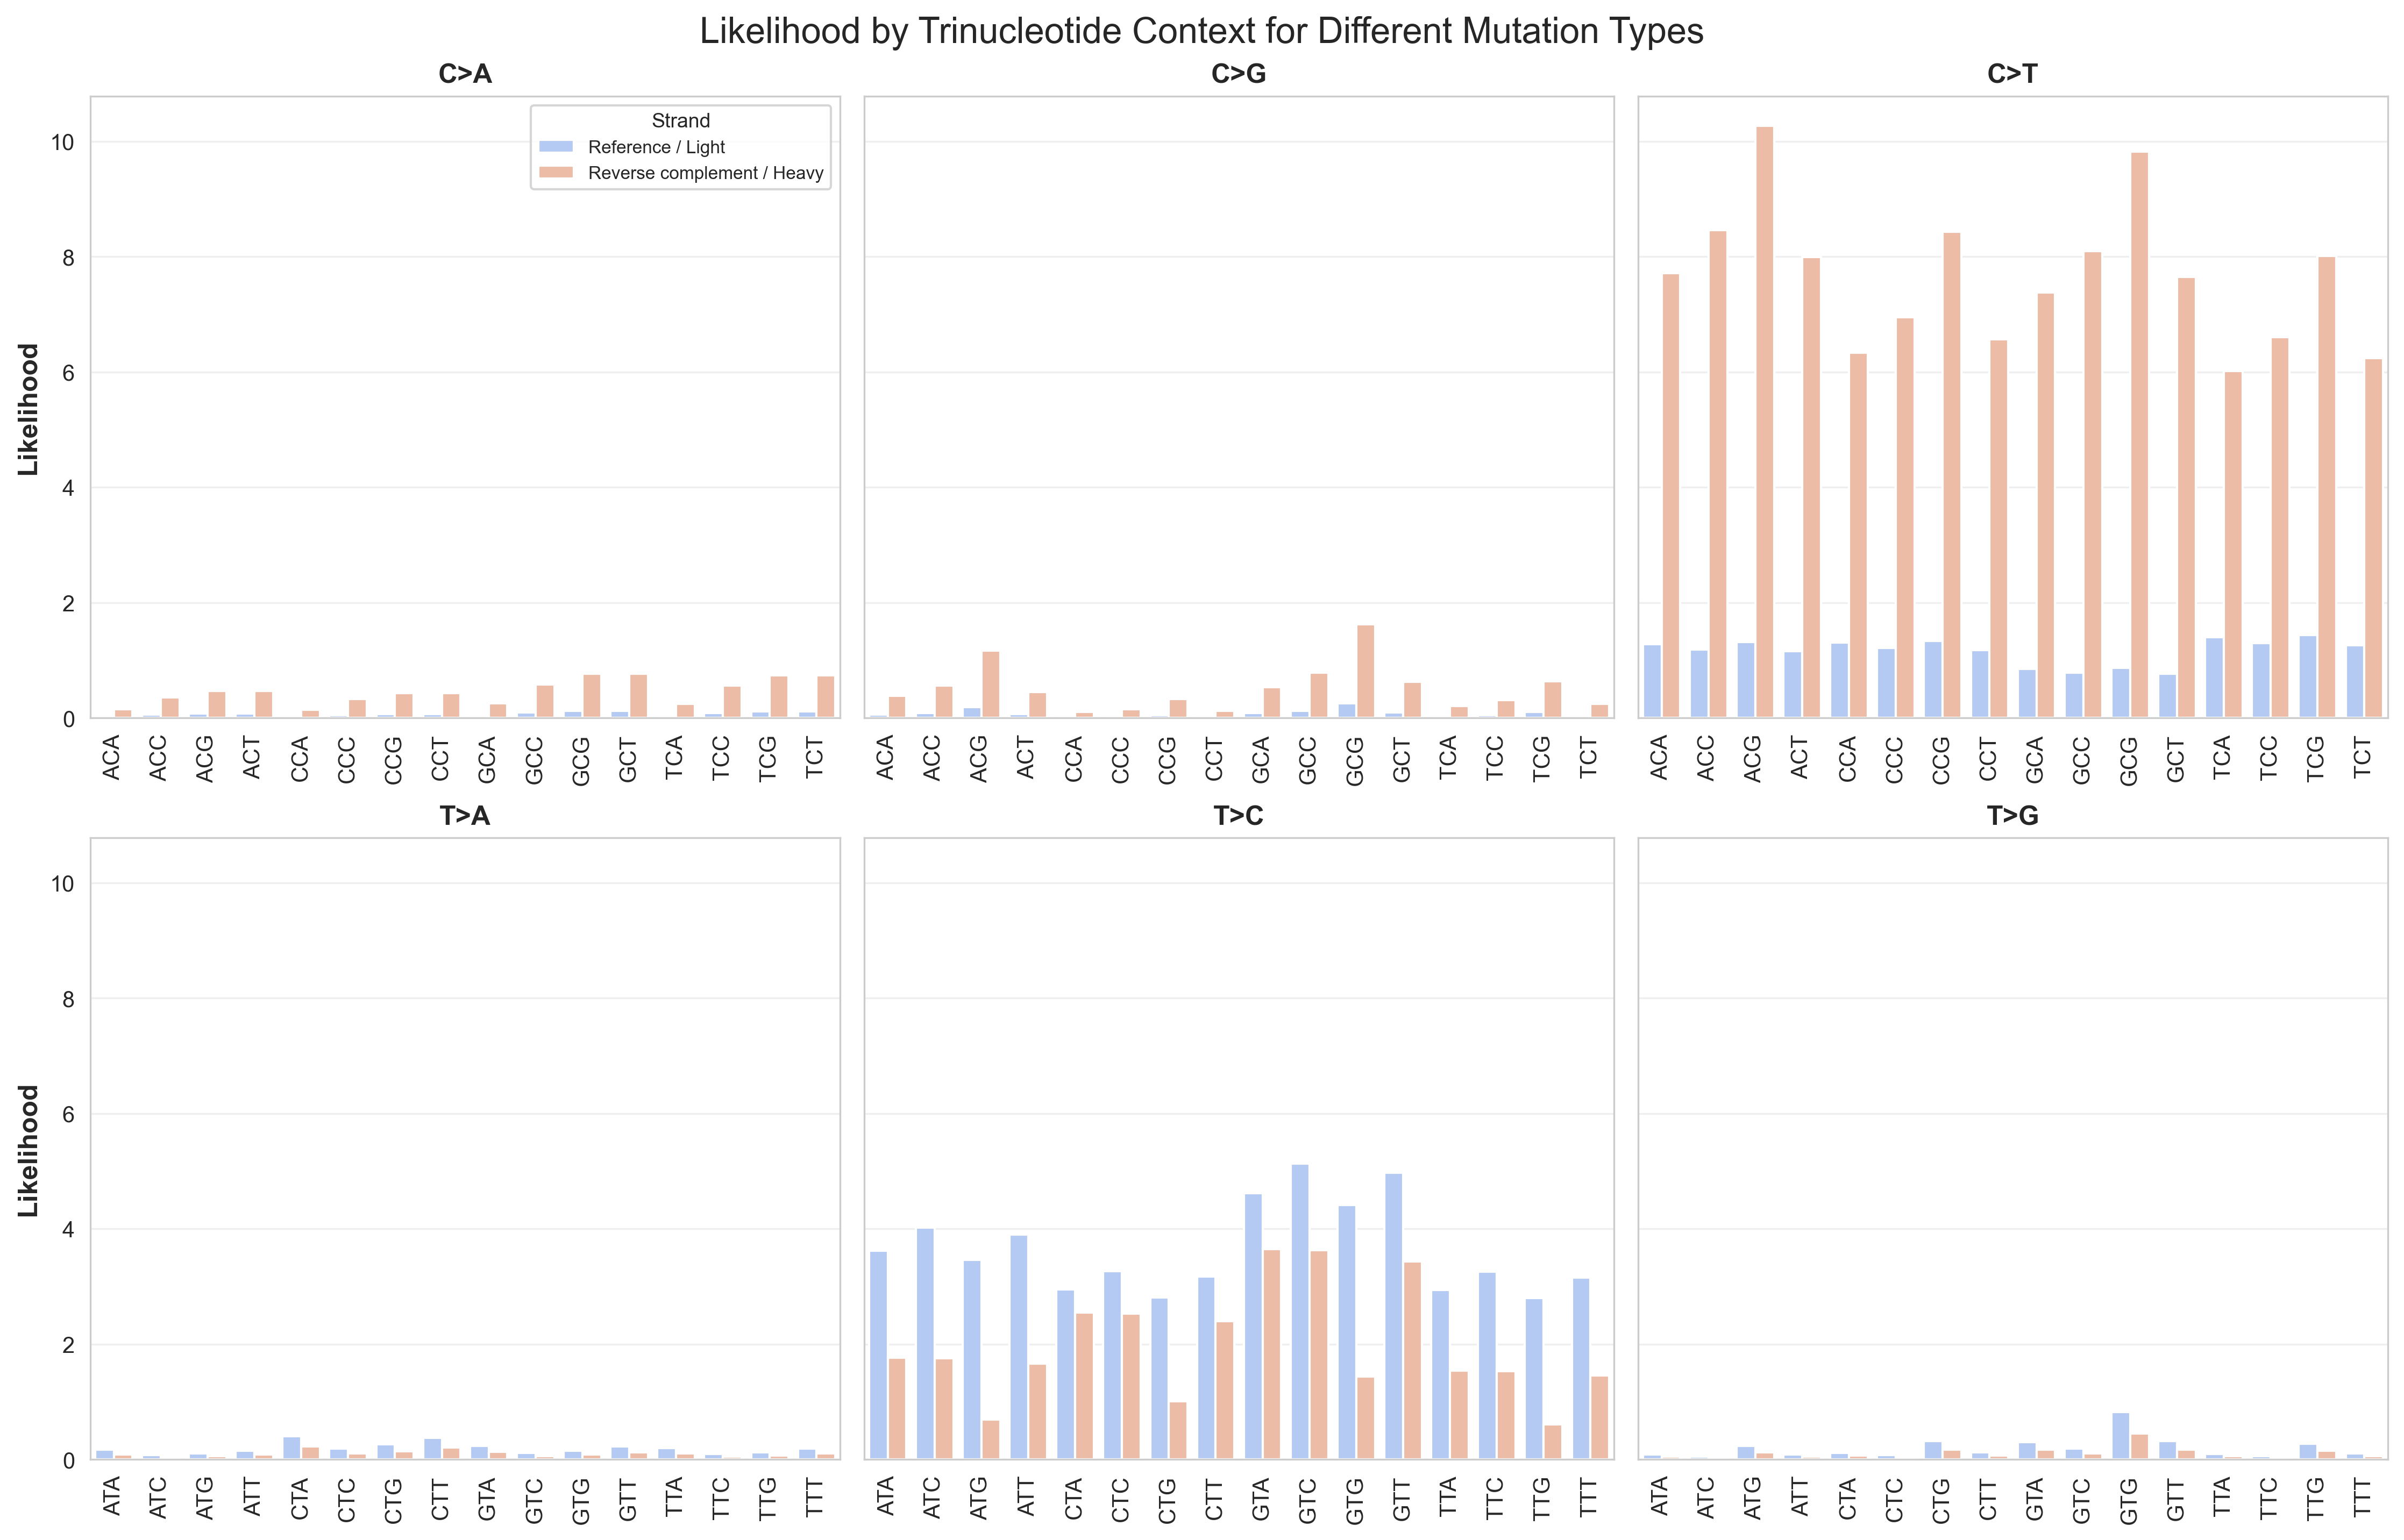

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 设置图形样式
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 使用支持更多字符的字体
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# 创建2行3列的图形布局
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300, sharey=True)#, constrained_layout=True
fig.suptitle('Likelihood by Trinucleotide Context for Different Mutation Types', 
             fontsize=16, y=0.95)

# 获取所有唯一的pyr_mut类型
pyr_mut_types = sum_plot['pyr_mut'].unique()
print(f"找到的突变类型: {pyr_mut_types}")

# 为每个突变类型创建子图
for i, mut_type in enumerate(pyr_mut_types):
    # 计算子图位置（2行3列）
    row = i // 3  # 行索引：0或1
    col = i % 3   # 列索引：0,1,2
    
    # 筛选当前突变类型的数据
    mut_data = sum_plot[(sum_plot['pyr_mut']== mut_type) & (sum_plot['Likelihood']!=0)]
    
    # 在当前子图位置绘制条形图
    ax = axes[row, col]
    
    # 使用seaborn绘制条形图，按strand分组
    sns.barplot(x='pyr_tri', y='Likelihood', hue='strand', 
                data=mut_data, palette='coolwarm', ax=ax)
    
    # 设置子图标题和标签
    ax.set_title(f'{mut_type}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Likelihood', fontsize=12, fontweight='bold')
    # 旋转x轴标签
    ax.tick_params(axis='x', rotation=90)
    
    # 添加网格线
    ax.grid(True, alpha=0.3, axis='y')
    
    # 调整图例
    if i == 0:  # 只在第一个子图显示完整图例
        ax.legend(title='Strand', fontsize=8, title_fontsize=9)
    else:
        ax.legend().remove()  # 其他子图移除图例避免重复

# 调整子图间距
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # 为总标题留出空间

plt.show()